In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [2]:
to_pil_image = transforms.ToPILImage()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


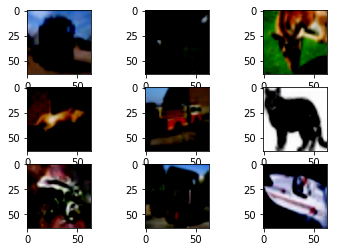

In [52]:
for i, image in enumerate(dataloader, 0):
    plt.figure()
    for k in range(9):
        img = image[0][k,:,:,:]  # plt.imshow()只能接受3-D Tensor，所以也要用image[0]消去batch那一维
        img = img.numpy()  # FloatTensor转为ndarray
        img = np.transpose(img, (1, 2, 0))  # 把channel
        plt.subplot(3,3,k+1)
        plt.imshow(img)
    break
    


In [3]:

workers=1
batchSize = 64
imageSize = 64
nz = 100
ngf = 64
ndf =64
niter = 25
lr = 0.001
beta1 = 0.6 #adam
cuda = True
ngpu =1
netG = ''
netD = ''#path
outf ='../outf'
nc=3
manualSeed = 9054


In [7]:
try:
    os.makedirs(outf)
except OSError:
    pass

if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


dataset = dset.CIFAR10(root='../data', download=True,
                           transform=transforms.Compose([
                               transforms.Resize(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))





assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(workers))

device = torch.device("cuda:0")



# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.021)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.021)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)



class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)


criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.99))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.99))

errd=np.array(list()) 
errg=np.array(list()) 
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real

        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real +  errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        errd = np.append(errd,errD.item())
        errg = np.append(errg,errG.item())
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if errD.item()>errG.item():
            for param_group in optimizerD.param_groups:
                param_group['lr'] = lr*3
        else:
            for param_group in optimizerD.param_groups:
                param_group['lr'] = lr
        if errD.item()<errG.item():
            for param_group in optimizerG.param_groups:
                param_group['lr'] = lr*3
        else:
            for param_group in optimizerG.param_groups:
                param_group['lr'] = lr
        if i % 100 == 0 and epoch>=3:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

  

Random Seed:  9054
Files already downloaded and verified
[0/25][0/782] Loss_D: 1.7808 Loss_G: 29.0331 D(x): 0.6388 D(G(z)): 0.6309 / 0.0000
[0/25][1/782] Loss_D: 3.8897 Loss_G: 27.9039 D(x): 0.3553 D(G(z)): 0.5794 / 0.0000
[0/25][2/782] Loss_D: 5.9533 Loss_G: 37.7879 D(x): 0.4126 D(G(z)): 0.7495 / 0.0000
[0/25][3/782] Loss_D: 2.3267 Loss_G: 34.5533 D(x): 0.5973 D(G(z)): 0.0000 / 0.0000
[0/25][4/782] Loss_D: 2.0961 Loss_G: 17.3818 D(x): 0.7409 D(G(z)): 0.3215 / 0.0000
[0/25][5/782] Loss_D: 16.9617 Loss_G: 7.4071 D(x): 0.7630 D(G(z)): 0.9951 / 0.0626
[0/25][6/782] Loss_D: 14.5663 Loss_G: 26.3604 D(x): 0.6435 D(G(z)): 0.9360 / 0.0000
[0/25][7/782] Loss_D: 3.5772 Loss_G: 22.3871 D(x): 0.4182 D(G(z)): 0.0000 / 0.0000
[0/25][8/782] Loss_D: 6.3016 Loss_G: 3.7104 D(x): 0.4664 D(G(z)): 0.2815 / 0.2587
[0/25][9/782] Loss_D: 5.8639 Loss_G: 4.4042 D(x): 0.6942 D(G(z)): 0.4838 / 0.3838
[0/25][10/782] Loss_D: 1.3206 Loss_G: 5.8632 D(x): 0.9250 D(G(z)): 0.4777 / 0.1925
[0/25][11/782] Loss_D: 0.3287 L

In [62]:
  # do checkpointing
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


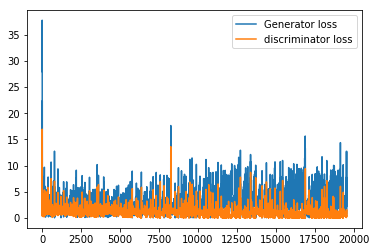

In [18]:
plt.plot(errg,label = "Generator loss" )
plt.plot(errd,label = 'discriminator loss')
plt.legend()
plt.savefig('loss.png',dpi = 500)

In [15]:
errg.shape

(19550,)